<h5>Paper title: XLR: A Universal Framework for Learning rate Adaptation via Exponential Range Exploration</h5>

<h5>Authors: Rakib Ul Haque and Panagiotis (Panos P.) Markopoulos</h5>

<h5>Affiliation: The University of Texas at San Antonio</h5>

<h5>Emails: rakibul.haque@utsa.edu; panagiotis.markopoulos@utsa.edu</h5>

<h5>Code by: rakibul.haque@utsa.edu</h5>

<h5>Date: 01/09/2025</h5>

<h5>Cite as: R. Ul Haque and P. Markopoulos, "XLR: A Universal Framework for Learning rate Adaptation via Exponential Range Exploration", 2025.</h5>

<h5>Datasets and weights repository: https://utsacloud-my.sharepoint.com/:f:/g/personal/rakibul_haque_utsa_edu/EiS5MQxqVS1Or0_VAypt81UBm8bFi_qk3qrswJyTTRBAzw?e=icgq3J</h5>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from collections import Counter
import random
import copy
import torch.nn.functional as F
import sys
import time
import pickle
import pandas as pd
import random
import queue
from collections import deque
from torch import Tensor
from typing import Type
import torchvision.models as models
import math
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
import math
import gc
import os

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified


In [3]:
def Print(string, dictionary):
    first_key = next(iter(dictionary))
    first_value = dictionary[first_key]
    print(f"{string}:{first_key}: {first_value[0][0]}\n")

In [4]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu5 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)  # Change output to 10 for CIFAR-10 classes

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.relu5(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [5]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute average loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    return test_loss, test_accuracy

In [6]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
val_losses = []
val_accuracies = []
learning_rate= []
learning_rate.append(None)
train_loss_rate=[]
val_loss_rate=[]

lr_up=[]
lr_up.append(0)
lr_up.append(0)

lr_down=[]
lr_down.append(0)
lr_down.append(0)

lr_overfit=[]
lr_overfit.append(0)
lr_overfit.append(0)


all_final_weights={}

min_lr=0.00001
max_lr=0.1
current_lr=min_lr

model_weights_queue = deque(maxlen=2)

flag=0

num_epochs = 50
n=5.0
steps=1



b_size=128
# num_epochs = 100
# le_rate=0.01

# opti="sgd"
# opti="adam"
# opti="adagrad"
# opti="adadelta"
opti="rmdprop"


# Initialize model
model_centralized = cnn()
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_centralized.to(device)

file_path = "s_cnn.pth"
initial_weights=torch.load(file_path, weights_only=True)
Print("Model's initial weights", initial_weights)

model_centralized.load_state_dict(initial_weights)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_centralized.parameters(), lr=min_lr)


if opti=="sgd":
    optimizer = torch.optim.SGD(model_centralized.parameters(), lr=min_lr)
elif opti=="adam":
    optimizer = torch.optim.Adam(model_centralized.parameters(), lr=min_lr)
elif opti=="adagrad":
    optimizer = torch.optim.Adagrad(model_centralized.parameters(), lr=min_lr)
elif opti=="adadelta":
    optimizer = torch.optim.Adadelta(model_centralized.parameters(), lr=min_lr)
elif opti=="rmdprop":
    optimizer = torch.optim.RMSprop(model_centralized.parameters(), lr=min_lr)

# name="expoenetial_Adam_ovefit_condition_H=0001"

name=f"ex_with_overfit_H0001_{opti}_{b_size}_{num_epochs}"

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


subset_dataset = torch.load('val_dataset.pth',weights_only=False)
remaining_dataset = torch.load('test_dataset.pth',weights_only=False)
val_loader = DataLoader(subset_dataset, batch_size=b_size, shuffle=False)
test_loader = DataLoader(remaining_dataset, batch_size=b_size, shuffle=False)


Model's initial weights:conv1.weight: tensor([[ 0.1329, -0.1625,  0.0656],
        [ 0.0480,  0.0967,  0.0128],
        [ 0.1696,  0.0517, -0.0104]], device='cuda:0')



In [7]:
#round zero
train_loss, train_accuracy = evaluate(model_centralized, train_loader, criterion, device)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

val_loss, val_accuracy = evaluate(model_centralized, val_loader, criterion, device)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)

test_loss, test_accuracy = evaluate(model_centralized, test_loader, criterion, device)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f"train_loss {train_loss}, val_loss {val_loss}")


train_loss 2.3027027763064254, val_loss 2.3027840137481688


In [8]:
def lr_increase(n, steps, c_lr, min_lr, max_lr):
    print(f"previous LR  {c_lr}, steps {steps}")
    n=max(n-steps,1)
    min_lr=(10 ** ( (-1)*n ))
    c_lr=min(min_lr, max_lr)
    print(f"calcualted LR  {c_lr}, updatred n is {n}")
    return c_lr, min_lr, max_lr, n


def lr_decrease(n,steps, c_lr, min_lr, max_lr):
    max_lr=(10 ** ( (-1)*n ))
    n=n+steps
    min_lr=(10 ** ( (-1)*n ))
    steps=steps/10
    min_lr=max(min_lr,(10 ** -5))
    c_lr=min_lr
    print(f"calcualted LR  {c_lr}, updated steps {steps}, updated values of n {n}")
    return c_lr, min_lr, max_lr, steps, n    

def lr_overfitcase(n,steps, c_lr, min_lr, max_lr):
    max_lr=(10 ** ( (-1)*n ))
    steps=(1/10)
    n=n+1
    min_lr=(10 ** ( (-1)*n ))
    #steps=steps*10
    min_lr=max(min_lr,(10 ** -5))
    c_lr=min_lr
    print(f"=====over fitting case calcualted LR  {c_lr}, updated steps {steps}, updated values of n {n}")
    return c_lr, min_lr, max_lr, steps, n    

In [9]:
def custom_round(lr):
    if lr < 0.0001:  # Values less than 0.001 round to 4 decimal places
        return float(f"{lr:.5f}")
    elif lr < 0.001:  # Values between 0.001 and 0.01 round to 3 decimal places
        return float(f"{lr:.4f}")
    elif lr < 0.01:  # Values between 0.01 and 0.1 round to 2 decimal places
        return float(f"{lr:.3f}")
    elif lr < 0.1:  # Values between 0.01 and 0.1 round to 2 decimal places
        return float(f"{lr:.3f}")
    elif lr>=0.1:  # Values 0.1 and above round to 1 decimal place
        return float(f"{lr:.1f}")

In [10]:
# Initialize lists to store metrics

for epoch in range(1,num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    # Train the model and get train loss and accuracy
    #train_loss, train_accuracy = train(model_centralized, train_loader, criterion, optimizer, device)
    model_centralized.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_centralized(inputs)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Accumulate loss
        running_loss += loss.item()
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Compute average loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    learning_rate.append(current_lr)
    
    model_weights_queue.append(copy.deepcopy(model_centralized.state_dict()))

    #===========================================================================================
    # Evaluate the model and get test loss and accuracy
    val_loss, val_accuracy = evaluate(model_centralized, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    test_loss, test_accuracy = evaluate(model_centralized, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"val Loss: {val_loss}, val Accuracy: {val_accuracy:.2f}%")

    tlr=((train_losses[epoch]-train_losses[epoch-1])/train_losses[epoch-1])*100
    vlr=((val_losses[epoch]-val_losses[epoch-1])/val_losses[epoch-1])*100
    print(f"train loss rate {tlr}, val loss rate {vlr}")

    train_loss_rate.append(tlr)
    val_loss_rate.append(vlr)

    if epoch==1:
        #if round(val_losses[epoch], 4) <= round(val_losses[epoch-1],4) and round(train_losses[epoch],4) <= round(train_losses[epoch-1],4):
        # if (tlr<=0.001) and (vlr<=0.001):
        current_lr, min_lr, max_lr,n = lr_increase(n, steps, current_lr, min_lr, max_lr)
        optimizer.param_groups[0]['lr'] = custom_round(current_lr)
        print("Learning rate increased")
        flag=0
            
    if epoch>1:
        #if round(val_losses[epoch], 4) <= round(val_losses[epoch-1],4) and round(train_losses[epoch],4) <= round(train_losses[epoch-1],4):
        lr_up.append( (tlr<=-0.0001) and (vlr<=-0.0001) )
        lr_down.append( (tlr>=0.0001) and (vlr>=0.0001) )
        lr_overfit.append( (tlr<=-0.0001) and (vlr>=0.0001) )
        
        if (tlr<=-0.0001) and (vlr<=-0.0001):
            current_lr, min_lr, max_lr,n = lr_increase(n, steps, current_lr, min_lr, max_lr)
            optimizer.param_groups[0]['lr'] = custom_round(current_lr)
            print("Learning rate increased")
            flag=0
        #elif round(val_losses[epoch], 4) > round(val_losses[epoch-1],4) and round(train_losses[epoch],4) > round(train_losses[epoch-1],4):
        elif (tlr>=0.0001) and (vlr>=0.0001):
            current_lr, min_lr, max_lr, steps,n = lr_decrease(n, steps,  current_lr, min_lr, max_lr)
            optimizer.param_groups[0]['lr'] = custom_round(current_lr)
            all_final_weights = model_weights_queue.popleft()
            Print(f"loded weights",all_final_weights )
            flag=0
            model_weights_queue.clear()
            model_centralized.load_state_dict(all_final_weights)
    
            model_weights_queue.append(all_final_weights)
            
            train_losses.pop()
            train_losses.append(train_losses[epoch-1])
            
            train_accuracies.pop()
            train_accuracies.append(train_accuracies[epoch-1])
            
            test_losses.pop()
            test_losses.append(test_losses[epoch-1])
            
            test_accuracies.pop()
            test_accuracies.append(test_accuracies[epoch-1])
            
            val_losses.pop()
            val_losses.append(val_losses[epoch-1])
            
            val_accuracies.pop()
            val_accuracies.append(val_accuracies[epoch-1])
            
            learning_rate.pop()
            learning_rate.append(learning_rate[epoch-1])
            
            print("Learning rate decreased")
        # elif round(val_losses[epoch], 4) > round(val_losses[epoch-1],4) and round(train_losses[epoch],4) <= round(train_losses[epoch-1],4):
        elif (tlr<=-0.0001) and (vlr>=0.0001):
            flag=flag+1
            if flag>2:
                flag=0
                # break
                current_lr, min_lr, max_lr, steps,n = lr_overfitcase(n, steps,  current_lr, min_lr, max_lr)
                optimizer.param_groups[0]['lr'] = custom_round(current_lr)
                
                all_final_weights = model_weights_queue.popleft()
                Print(f"loded weights",all_final_weights )
                model_weights_queue.clear()
                model_centralized.load_state_dict(all_final_weights)
    
                model_weights_queue.append(all_final_weights)
                
                train_losses.pop()
                train_losses.append(train_losses[epoch-1])
                
                train_accuracies.pop()
                train_accuracies.append(train_accuracies[epoch-1])
                
                test_losses.pop()
                test_losses.append(test_losses[epoch-1])
                
                test_accuracies.pop()
                test_accuracies.append(test_accuracies[epoch-1])
                
                val_losses.pop()
                val_losses.append(val_losses[epoch-1])
                
                val_accuracies.pop()
                val_accuracies.append(val_accuracies[epoch-1])
                
                learning_rate.pop()
                learning_rate.append(learning_rate[epoch-1])
                
                print("Learning rate decreased")
            
    print(f"flag {flag}, current_LR {custom_round(current_lr)}, min_lr {min_lr}, max_lr {max_lr}, current values of n is {n}.\n\n")

Epoch 1/50
Train Loss: 2.1701040880759352, Train Accuracy: 20.87%
Test Loss: 2.0179477364329967, Test Accuracy: 27.27%
val Loss: 2.0332576036453247, val Accuracy: 27.24%
train loss rate -5.758393553647453, val loss rate -11.704372120603027
previous LR  1e-05, steps 1
calcualted LR  0.0001, updatred n is 4.0
Learning rate increased
flag 0, current_LR 0.0001, min_lr 0.0001, max_lr 0.1, current values of n is 4.0.


Epoch 2/50
Train Loss: 1.898770082332289, Train Accuracy: 30.55%
Test Loss: 1.6170285738120644, Test Accuracy: 42.67%
val Loss: 1.6338533341884613, val Accuracy: 40.48%
train loss rate -12.503271489812143, val loss rate -19.643564531163765
previous LR  0.0001, steps 1
calcualted LR  0.001, updatred n is 3.0
Learning rate increased
flag 0, current_LR 0.001, min_lr 0.001, max_lr 0.1, current values of n is 3.0.


Epoch 3/50
Train Loss: 1.8553625122665445, Train Accuracy: 31.83%
Test Loss: 1.485631473993851, Test Accuracy: 43.92%
val Loss: 1.4667423009872436, val Accuracy: 44.80%

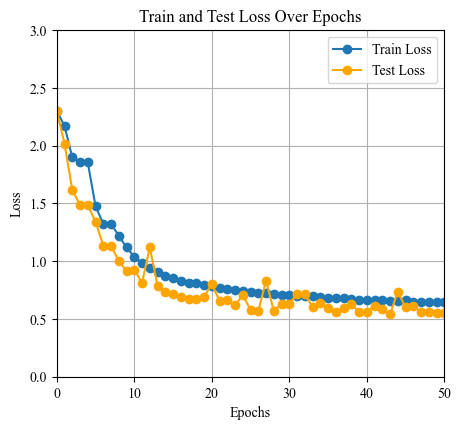

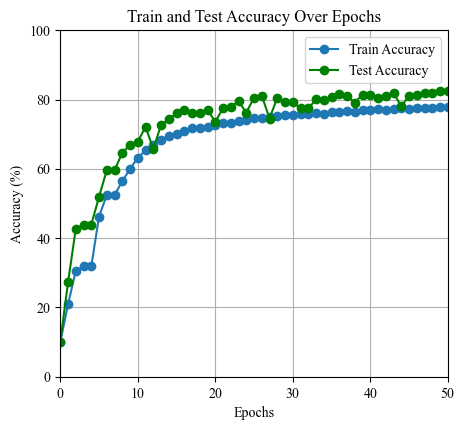

In [11]:
import matplotlib.pyplot as plt

# Plot Train and Test Loss
plt.figure(figsize=(5, 4.5))
plt.plot(range(0, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(0, num_epochs+1), test_losses, label="Test Loss", marker='o', color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.xlim(0, 50)  # X-axis from 0 to 50
plt.ylim(0, 3)   # Y-axis from 0 to 4 for loss
plt.legend()
plt.grid()
# Save the plot
# plt.savefig(f"{name}_train_test_loss_curve.png")
plt.show()

# Plot Train and Test Accuracy
plt.figure(figsize=(5, 4.5))
plt.plot(range(0, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(0, num_epochs+1), test_accuracies, label="Test Accuracy", marker='o', color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train and Test Accuracy Over Epochs")
plt.xlim(0, 50)  # X-axis from 0 to 50
plt.ylim(0, 100) # Y-axis from 0 to 100 for accuracy
plt.legend()
plt.grid()
# Save the plot
# plt.savefig(f"{name}_train_test_accuracy_curve.png")
plt.show()


In [13]:
import pandas as pd
import os

# Ensure the directory exists
os.makedirs(name, exist_ok=True)

# Combine all lists into a dictionary
data = {
    "Train Losses": train_losses,
    "Train Accuracies": train_accuracies,
    "Test Losses": test_losses,
    "Test Accuracies": test_accuracies,
    "Validation Losses": val_losses,
    "Validation Accuracies": val_accuracies,
    "Learning Rate": learning_rate,
    "lr_up":lr_up,
    "lr_down":lr_down,
    "lr_overfit":lr_overfit,
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
file_path = f'{name}/{name}_metrics.csv'
df.to_csv(file_path, index=False)

print(f"Metrics saved to '{file_path}'")


Metrics saved to 'ex_with_overfit_H0001_rmdprop_128_50/ex_with_overfit_H0001_rmdprop_128_50_metrics.csv'


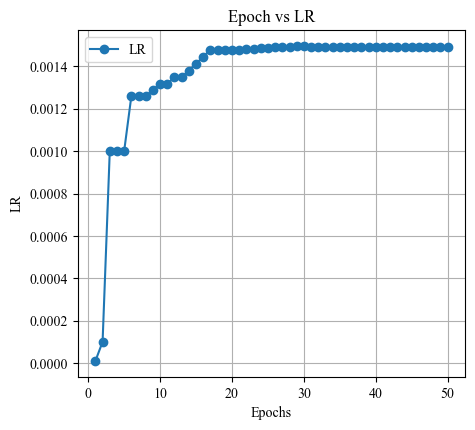

In [14]:
# Plot Train and Test Accuracy
plt.figure(figsize=(5, 4.5))
plt.plot(range(0, num_epochs + 1), learning_rate, label="LR", marker='o')
# plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy", marker='o', color="green")
plt.xlabel("Epochs")
plt.ylabel("LR")
plt.title("Epoch vs LR")
plt.legend()
plt.grid()
# Save the plot
# plt.savefig(f"{name}_Epoch_LR.png")
plt.show()
